In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

import spl.functional as spf
from spl.generators import SSPGenerator

In [11]:
# -----------------------------
# Hyperparameter Configuration
# -----------------------------
axis_resolution: int = 128
axis_limit: int = 5
length_scale: int = 0.5
random_seed: int = 0
vsa_dimensions: int = 2038

device: str = torch.device("cpu")

In [12]:
# -----------------------------------
# Initialize Libraries and Utilities
# -----------------------------------
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

ssp_gen = SSPGenerator(
    dimensionality=vsa_dimensions,
    device=device
)

In [13]:
# -------------------------
# Specify Object Locations
# -------------------------
label_vectors: dict = {
    "class": spf.make_good_unitary(vsa_dimensions, device),
    "x": spf.make_good_unitary(vsa_dimensions, device),
}

objects: dict = {
    "fox": {
        "locations": torch.tensor([[0]]),
        "symbol": spf.make_good_unitary(vsa_dimensions, device)
    }
}

In [14]:
# -----------------------------------
# Initialize Spatial Data Structures
# -----------------------------------
x_axis = torch.linspace(-axis_limit, axis_limit, axis_resolution, device=device)
x_axis = x_axis.reshape((-1, 1))

axis_basis_vectors: torch.tensor = ssp_gen.generate(1)

x_axis_matrix = torch.zeros((axis_resolution, vsa_dimensions), device=device)
for i, x in enumerate(x_axis):
    x_axis_matrix[i, :] = spf.power(axis_basis_vectors[0], x, length_scale)

In [15]:
# --------------
# Create Memory
# --------------
memory = torch.zeros(vsa_dimensions, device=device)

for object_key in objects:
    symbol_vector: torch.tensor = objects[object_key]["symbol"]
    locations: torch.tensor = objects[object_key]["locations"]

    # encode each location is cartesian space to hyperdimensional space
    location_vectors = torch.zeros((locations.shape[0], vsa_dimensions))
    for i in range(locations.shape[0]):
        location_vectors[i, :] = spf.power(axis_basis_vectors[0], locations[i], length_scale=length_scale)

    # bind each location vector with the associated symbol
    for i in range(locations.shape[0]):
        vs = [location_vectors[i, :], symbol_vector]
        location_vectors[i, :] = spf.bind(vs, device)

    for i in range(locations.shape[0]):
        memory += location_vectors[i, :]

Text(0, 0.5, 'Probability')

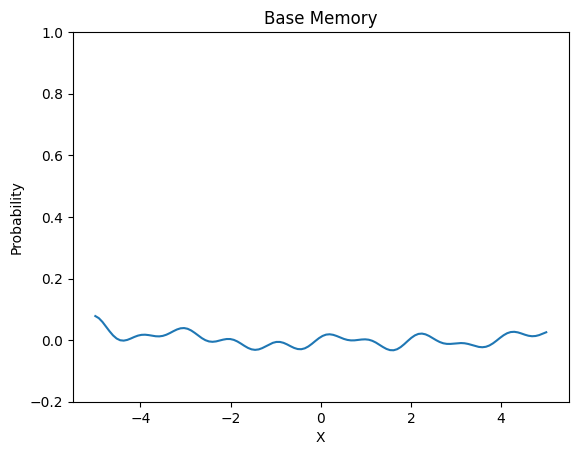

In [16]:
results = torch.sum(memory * x_axis_matrix, dim=1)

plt.title("Base Memory")
plt.plot(x_axis, results)
plt.ylim(-0.2, 1)
plt.xlabel("X")
plt.ylabel("Probability")

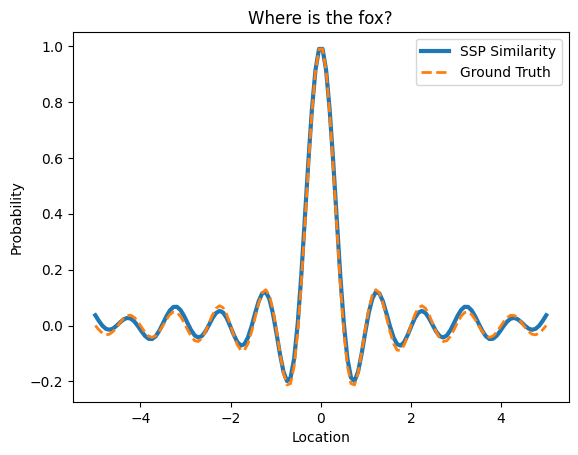

In [17]:
vs = [spf.invert(objects["fox"]["symbol"]), memory]
fox_decoded = spf.bind(vs, device)
results = torch.sum(fox_decoded * x_axis_matrix, dim=1)

plt.title("Where is the fox?")
plt.plot(x_axis, results, label="SSP Similarity", linewidth=3)
plt.plot(x_axis, np.sinc(2 * (x_axis)), label="Ground Truth", linestyle="--", linewidth=2)
plt.xlabel("Location")
plt.ylabel("Probability")
plt.legend()